In [3]:
import numpy as np
from math import log
import numpy.random as rn
import graph_tool as gt
import pickle as cp
import itertools
from matplotlib import pyplot as plt
%matplotlib inline
from InferC import *
import copy

In [4]:

def vmtoG(VM,M):#creates graph corresponding to configuration given my vertex maps and motifs
    elist=[]
    for i in range(len(VM)):
        for vmap in VM[i]:
            for e in M[i].edges():
                elist.append([vmap[M[i].vertex_index[e.source()]],vmap[M[i].vertex_index[e.target()]]])
    g=gt.Graph(directed=M[0].is_directed())
    g.add_edge_list(elist)
    return g
def CtoG(C):
    return vmtoG(C[0],C[1])


In [5]:
#Functions for shuffling subgraph configuration for different models 
def randomize(vm,m,SN,o):
    for s in range(SN):
        a=rn.choice(len(vm),2)
        i1=rn.choice(list(m.gp.orbits[o]))
        i2=rn.choice(list(m.gp.orbits[o]))
        o1=vm[a[0]][i1]
        o2=vm[a[1]][i2]
        if (vm[a[0]][i1] not in [i for i in vm[a[1]] if i!=vm[a[1]][i2]]) and (vm[a[1]][i2] not in [i for i in vm[a[0]] if i!=vm[a[0]][i1]]):
            vm[a[0]][i1]=o2
            vm[a[1]][i2]=o1
    return vm
def randomizeH(vm,m,N): #non-DC model
    for i in range(len(vm)):
        vm[i]=np.random.choice(N,len(vm[i]),replace=False).list
    return vm
#@jit
def randomizeNO(vm,m,SN):#motif degree model
    for s in range(SN):
        a=rn.choice(len(vm),2)
        i1=rn.choice(range(m.num_vertices()))
        i2=rn.choice(range(m.num_vertices()))
        o1=vm[a[0]][i1]
        o2=vm[a[1]][i2]
        if (vm[a[0]][i1] not in [i for i in vm[a[1]] if i!=vm[a[1]][i2]]) and (vm[a[1]][i2] not in [i for i in vm[a[0]] if i!=vm[a[0]][i1]]):
            vm[a[0]][i1]=o2
            vm[a[1]][i2]=o1
    return vm

#@jit
def randomizeCO(c,SN):
    C=copy.deepcopy(c)
    for i in range(len(C[1])):
        for o in range(len(C[1][i].gp.orbits)):
            C[0][i]=randomize(C[0][i],C[1][i],SN*len(C[0][i])*len(C[1][i].gp.orbits[o]),o)
    return C
#@jit     
def randomizeCNO(c,SN):
    C=copy.deepcopy(c)
    for i in range(len(C)):
        C[i][0]=randomizeNO(C[0][i],C[1][i],SN*len(C[0][i])*C[1][i].num_vertices())
    return C
#@jit
def randomizeCH(C):
    VM=C[0]
    M=C[1]
    g=vmtoG(VM,M)
    N=g.num_vertices()
    cr=copy.deepcopy(C)
    for i in range(len(cr[0])):
        cr[0][i]=randomizeH(C[0][i],C[1][i],N)
    return cr
#@jit
def randomizeCA(CS,SN):
    C=copy.deepcopy(CS)
    M=C[1]
    print(M[0])
    CA=[[t,j] for j in range(len(M)) for t in C[0][j]]
    chA=[i for i in range(len(CA)) for j in range(len(CA[i][0]))]
    for tt in range(SN*len(chA)):
        a=rn.choice(chA,2)
        i1=rn.choice(range(M[CA[a[0]][1]].num_vertices()))
        i2=rn.choice(range(M[CA[a[1]][1]].num_vertices()))
        o1=CA[a[0]][0][i1]
        o2=CA[a[1]][0][i2]
        if (o1 not in [i for i in CA[a[1]][0] if i!=o2]) and (o2 not in [i for i in CA[a[0]][0] if i!=o1]):
            CA[a[0]][0][i1]=o2
            CA[a[1]][0][i2]=o1
    Ms=[]
    m0=CA[0][1]
    vmap=[]
    cc=[]
    for i in CA:
        if i[1]==m0:
            cc.append(i[0])
        else:
            vmap.append(cc)
            Ms.append(M[m0])
            m0=i[1]
            cc=[i[0]]
    vmap.append(cc)
    Ms.append(M[m0])
    return [vmap,Ms]
#@jit
def randomizeCDAS(CS,SN):
    C=copy.deepcopy(CS)
    M=C[1]
    mdict={}
    for m in range(len(M)): #determine the orbit types of vertices of m
        vt=[[],[],[]]
        for v in range(M[m].num_vertices()):
                if M[m].vp.orbtype[v]==0:
                    vt[0].append(v)
                elif M[m].vp.orbtype[v]==1:
                    vt[1].append(v)
                elif M[m].vp.orbtype[v]==2:
                    vt[2].append(v)
        mdict[m]=vt
    CA=[[t,j] for j in range(len(M)) for t in C[0][j]]
    for t in range(3):
        chA=[i for i in range(len(CA)) for j in range(len(mdict[i[1]][t]))]
        for tt in range(SN):
            a=rn.choice(chA,2)
            i1=rn.choice(mdict[CA[a[0]][1]][t])
            i2=rn.choice(mdict[CA[a[1]][1]][t])
            o1=CA[a[0]][0][i1]
            o2=CA[a[1]][0][i2]
            if (o1 not in [i for i in CA[a[1]][0] if i!=o2]) and (o2 not in [i for i in CA[a[0]][0] if i!=o1]):
                CA[a[0]][0][i1]=o2
                CA[a[1]][0][i2]=o1
    Ms=[]
    m0=CA[0][1]
    vmap=[]
    cc=[]
    for i in CA:
        if i[1]==m0:
            cc.append(i[0])
        else:
            vmap.append(cc)
            Ms.append(M[m0])
            m0=i[1]
            cc=[i[0]]
    vmap.append(cc)
    Ms.append(M[m0])
    return [vmap,Ms]
    
        

In [6]:
def genDCS(m,D): # generate configuration of m-subgraphs for given orbit degree sequence D
    Dv=[rn.permutation(list(itertools.chain.from_iterable([[i]*ds[i] for i in range(len(ds))]))) for ds in D]
    print(len(Dv[0]))
    diter=[iter(d) for d in Dv]
    n=np.sum(D[0])/len(m.gp.orbits[0])
    print(n)
    vm=[]
    for i in range(int(n)):
        vm.append([next(diter[o]) for o in m.gp.orbmem])
    return vm
def genDCSC(M,Ds):
    C=[]
    for i in range(len(M)):
        D=[rn.permutation(Ds[i]*len(o)) for o in M[i].gp.orbits]
        C.append([genDCS(M[i],D),M[i]])
    return randomizeCO(C,100)
def genDCSCO(M,Ds,nm):
    vm=[]
    for i in range(len(M)):
        D=[sample(Ds[i][j],len(M[i].gp.orbits[j])*nm[i]) for j in  range(len(M[i].gp.orbits))]
        print(D[0][0])
        vm.append(genDCS(M[i],D))
    return randomizeCO([vm,M],100)
def genDCSNO(m,ds):
    Dv=rn.permutation(list(itertools.chain.from_iterable([[i]*ds[i] for i in range(len(ds))]))) 
    print(len(Dv))
    diter=iter(Dv)
    n=np.sum(ds)/m.num_vertices()
    print(n)
    vm=[]
    for i in range(n):
        vm.append([diter.next() for o in m.gp.orbmem])
    return vm
def genDCSCNO(M,Ds,nm):
    C=[]
    for i in range(len(M)):
        C.append([genDCSNO(M[i],sample(Ds[i],nm[i]*M[i].num_vertices())),M[i]])
    return randomizeCNO(C,100)    
def genDCSCA(M,dS,nm):
    n=sum([nm[i]*M[i].num_vertices() for i in range(len(M))])
    print(n)
    Dv=sampleS(dS,n)
    print(len(Dv))
    vmap=[]
    t=0
    for i in range(len(nm)):
        vm=[]
        for j in range(nm[i]):
            vm.append(Dv[t:t+M[i].num_vertices()])
            t+=M[i].num_vertices()
        vmap.append(vm)
    return randomizeCA([vmap,M],10)
        
def sample(ds,n):
    d=list(rn.choice(list(itertools.chain.from_iterable([[i]*ds[i] for i in range(len(ds))])),n))
    return np.array([d.count(i) for i in range(len(ds))])
def sampleS(ds,n):
    return list(rn.choice(list(itertools.chain.from_iterable([[i]*ds[i] for i in range(len(ds))])),n))
    
        

In [7]:
f=open('BDmotifs5','rb')
M=cp.load(f)
f.close()
print(len(M))

7585


[(2, 1, 1), (3, 3, 3), (3, 5, 1), (4, 7, 2), (5, 11, 2), (5, 20, 120)]


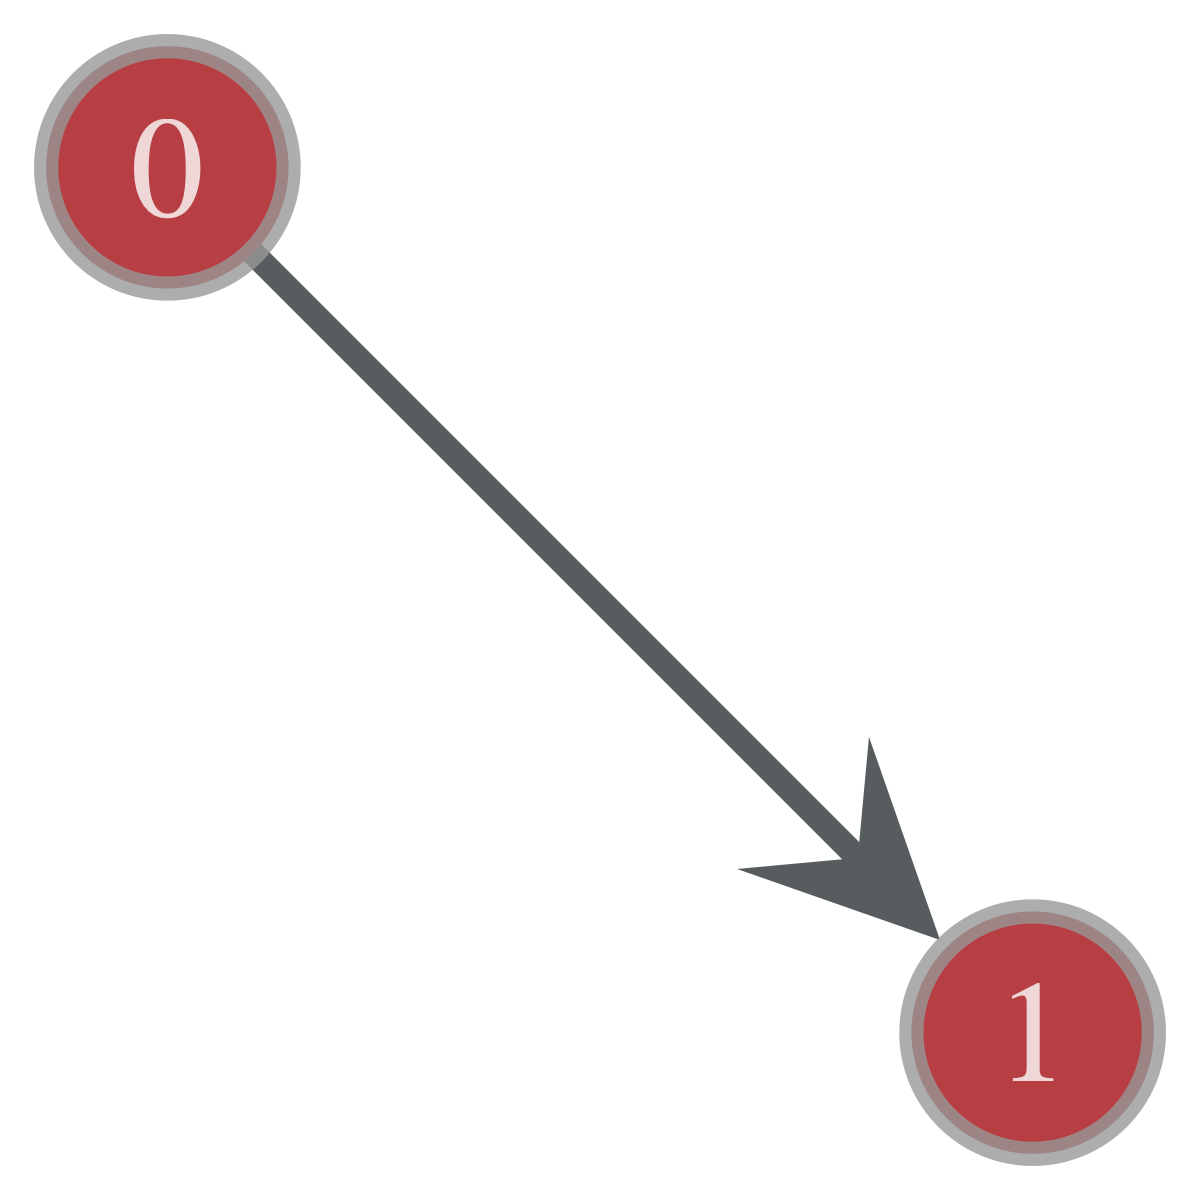

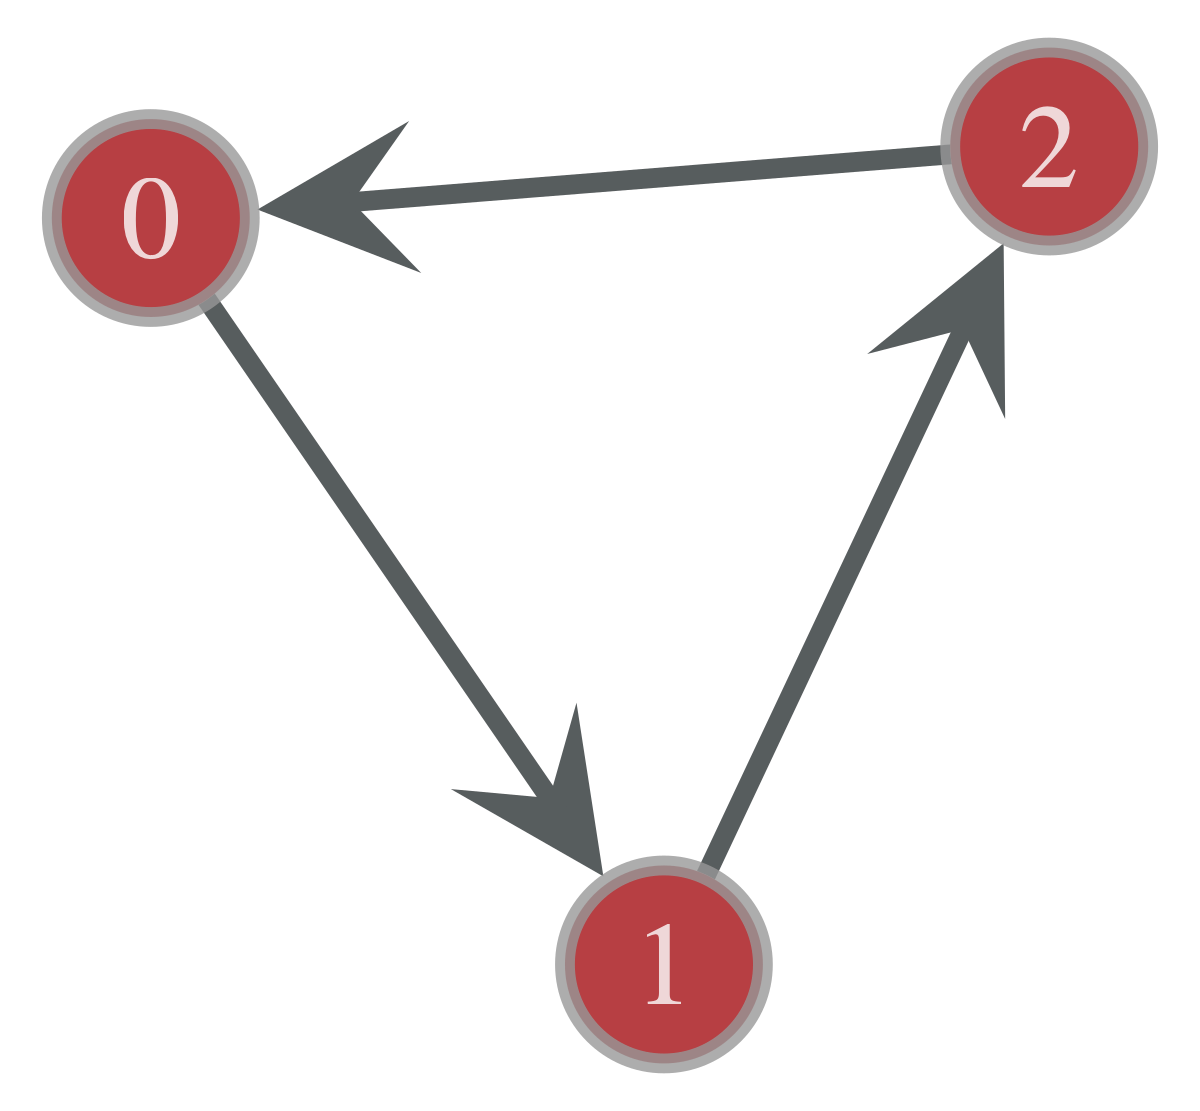

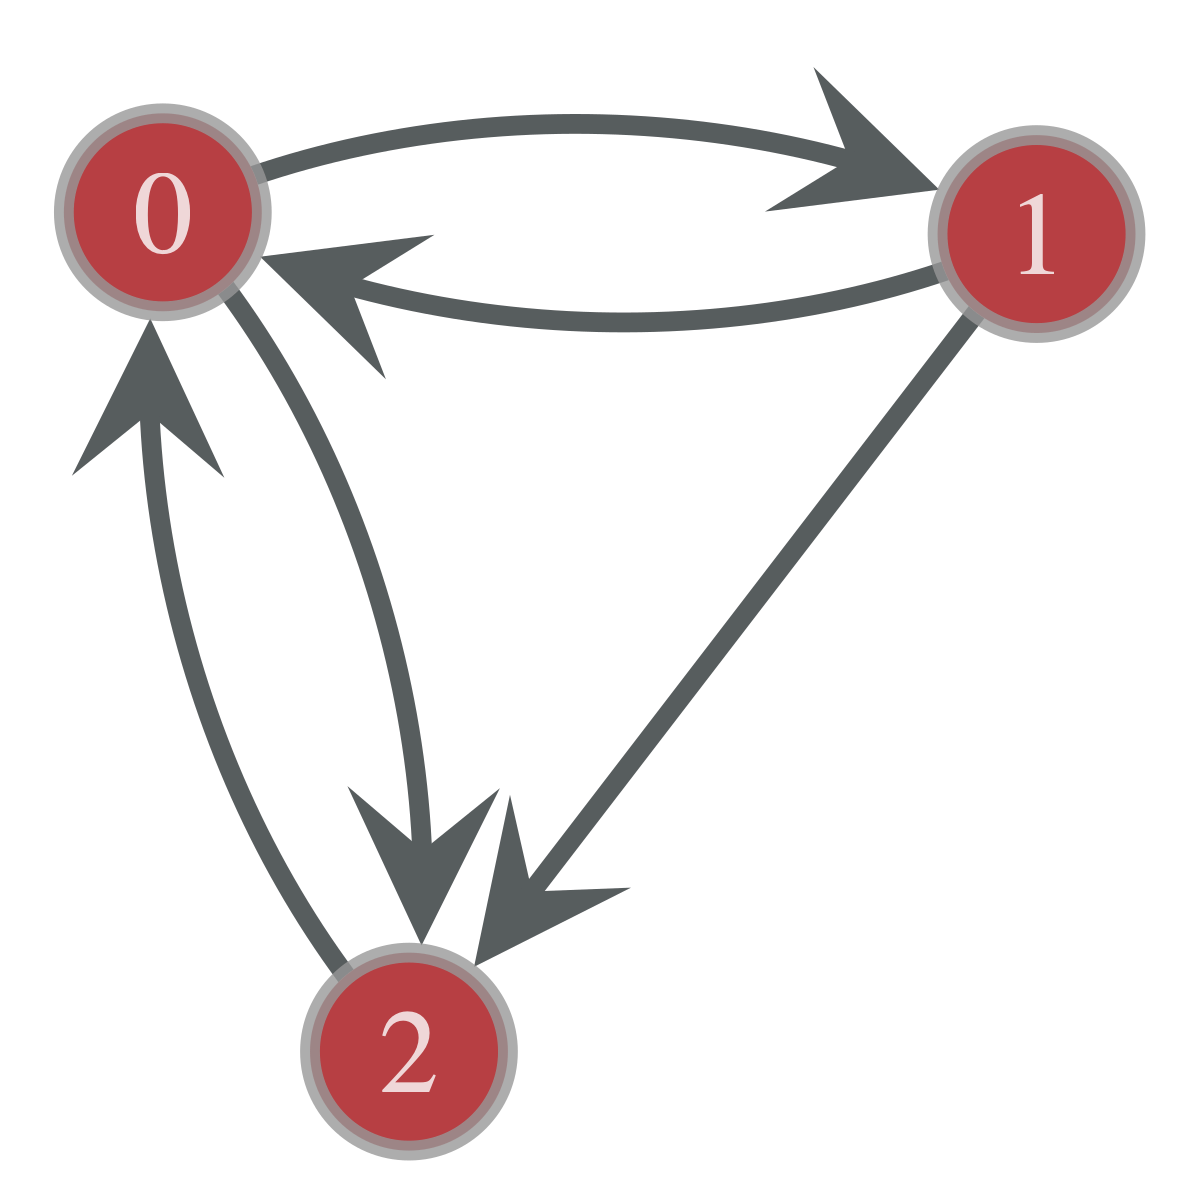

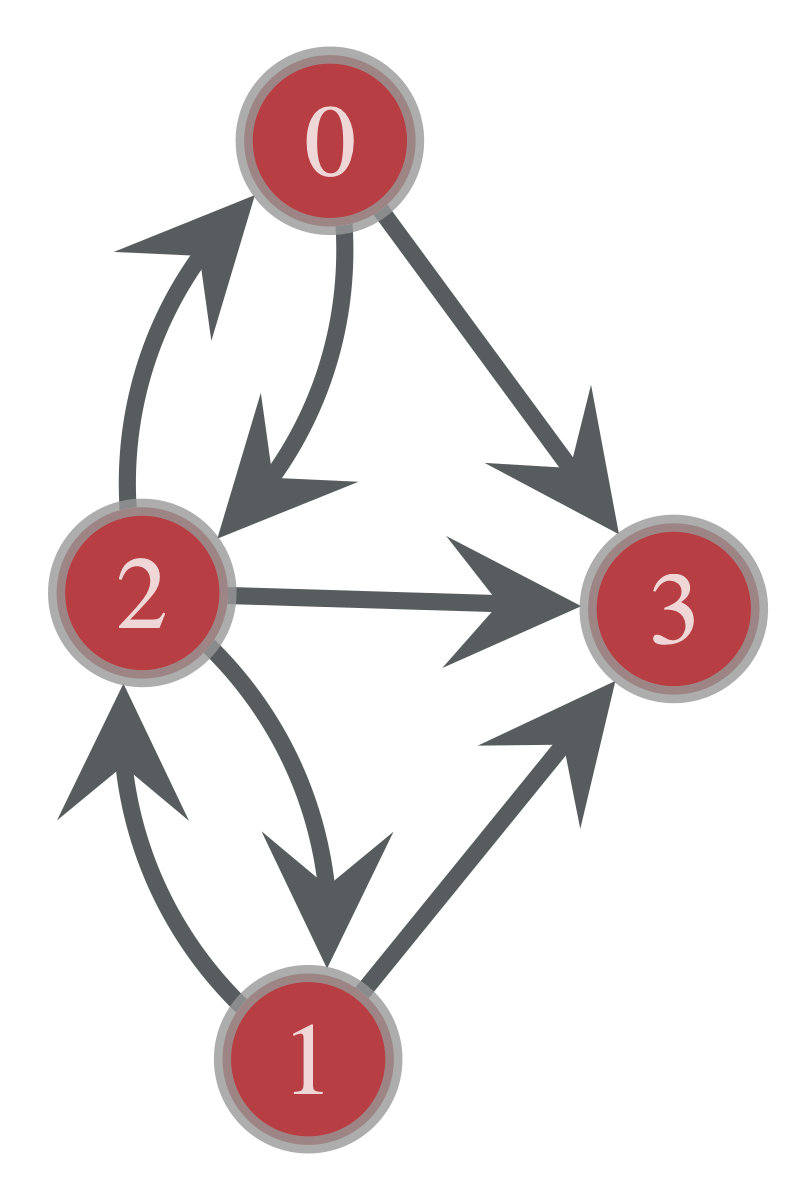

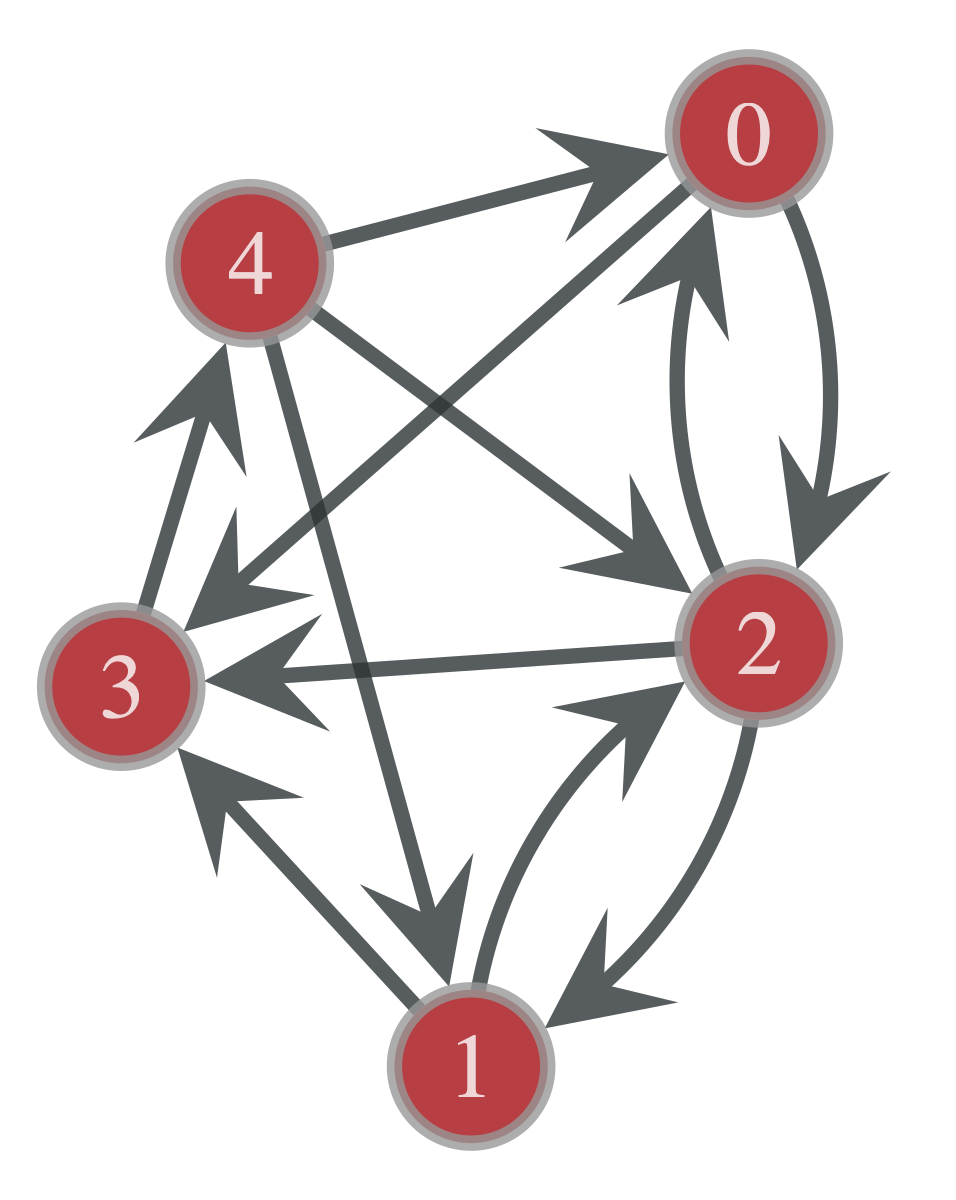

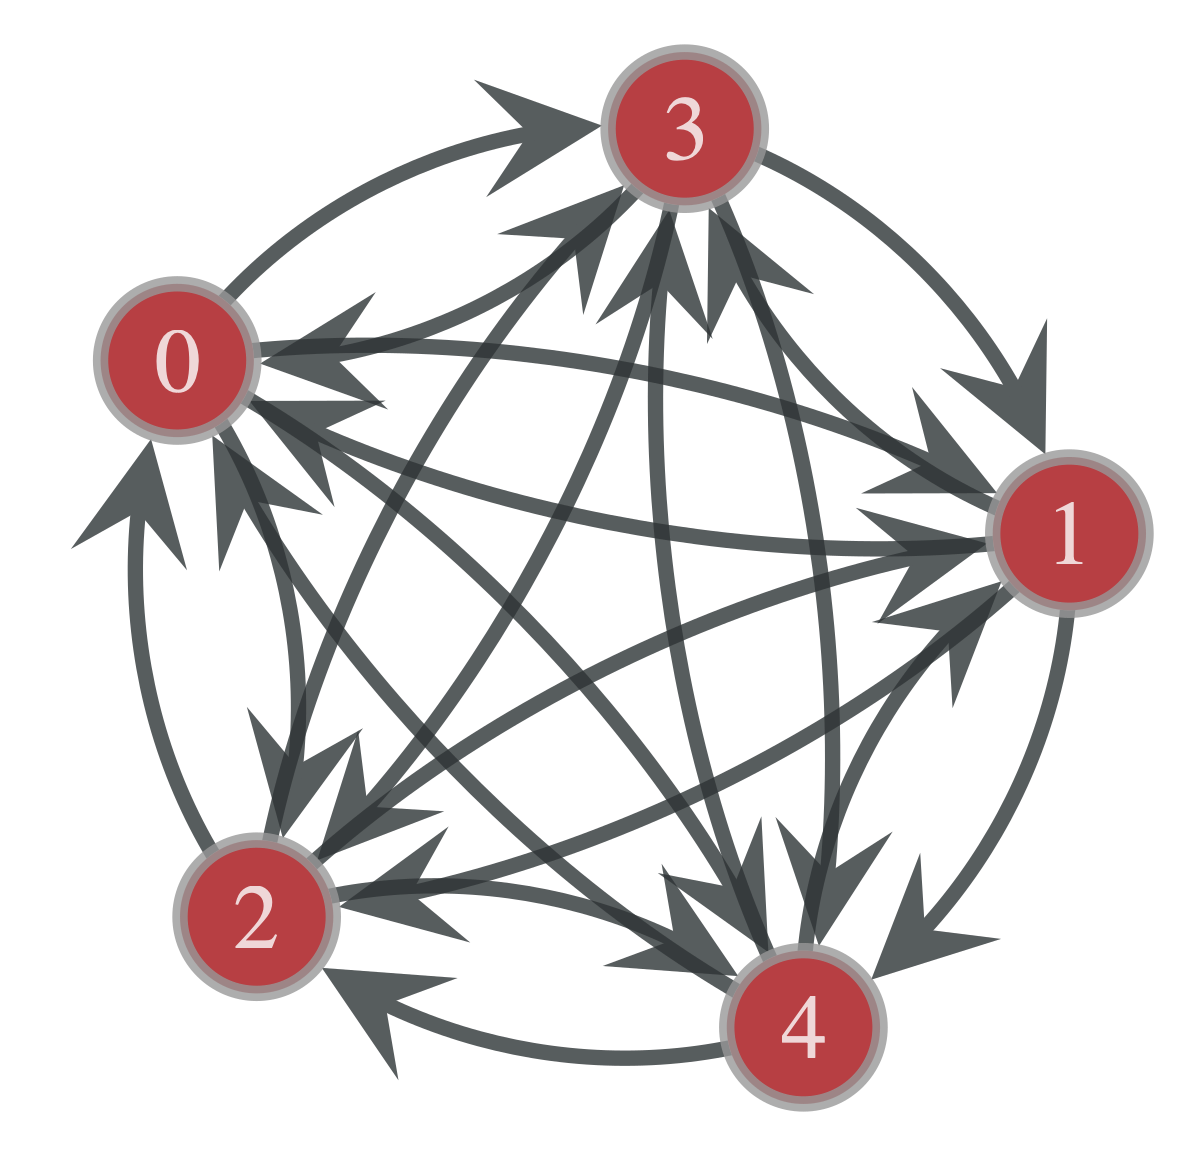

In [8]:

#pick set of motifs
ms=[M[0],M[3],M[7],M[58],M[5995],M[-1]]
print([(m.num_vertices(),m.num_edges(),m.gp.hom) for m in ms])
from graph_tool.draw import graph_draw
for m in ms:
    ug = gt.GraphView(m)
    graph_draw(ug,vertex_text=m.vertex_index.copy())

In [9]:
#generate
Ds=rn.zipf(len(ms),2000)
CRR=genDCSCA(ms,Ds,[500,100,100,100,100,25])
g=CtoG(CRR)
print(g)


2625
2625
<Graph object, directed, with 2 vertices and 1 edge, 6 internal graph properties, at 0x1bdbceef0>
<Graph object, directed, with 2000 vertices and 3600 edges, at 0x1192c9d20>
